<a href="https://colab.research.google.com/github/Dhyanesh-Panchal/GSR-research-and-stress-detection/blob/master/notebooks/LSTM_GSR_Phasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
from tqdm.notebook import tqdm as bar
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report,accuracy_score

import tensorflow as tf
from tensorflow import keras

In [39]:
data = pd.read_csv("https://raw.githubusercontent.com/Dhyanesh-Panchal/GSR-research-and-stress-detection/master/preprocessed_data/sub_1.csv").drop("Unnamed: 0",axis=1)
data = data[data["video"].isin([5,6,7,8])]

In [40]:
for id in bar(range(2,31)):
    sub_data = pd.read_csv(f"https://raw.githubusercontent.com/Dhyanesh-Panchal/GSR-research-and-stress-detection/master/preprocessed_data/sub_{id}.csv").drop("Unnamed: 0",axis=1)
    sub_data = sub_data[sub_data["video"].isin([5,6,7,8])]
    data = pd.concat([data,sub_data],axis=0)

  0%|          | 0/29 [00:00<?, ?it/s]

In [44]:
data = data.reset_index(drop=True)

In [21]:
def generate_windows_df(df: pd.DataFrame, window_size: int, window_gap: int, column_name: str):
        def rolling_window(df: pd.DataFrame, window_size: int, window_gap: int):
            windows = []
            for i in bar(range(0, len(df)-window_size+1, window_gap), desc="generating window"):
                single_window = df.iloc[i:i+window_size]
                # print(single_window)
                windows.append(single_window)
            return windows

        if window_size < len(df):
            windowed_data = rolling_window(
                df, window_size, window_gap)
            array = []
            for frame in bar(windowed_data, desc="preparing dataframe"):
                array.append(list(frame[column_name]))

            window_df = pd.DataFrame(np.array(array))
        else:
            return df
        return window_df

def pre_process(df):
  phasic_windowed = generate_windows_df(df, window_size=100, window_gap=1, column_name="EDA_Phasic")

  X = np.array(phasic_windowed).reshape(len(phasic_windowed),100,1)
  # inserted the initial arousal value during the "start" of window
  # X = np.concatenate((X,np.array(df['class_2_arousal'][99:]).reshape(len(df['class_2_arousal']) - 99,1,1)) , axis=1)

  y = np.array(df["class_2_arousal"])[99:]

  return X,y

# Approach_1

In [22]:
def prepare_data(subject_ID):
  data_df = pd.read_csv(f"https://raw.githubusercontent.com/Dhyanesh-Panchal/GSR-research-and-stress-detection/master/preprocessed_data/sub_{subject_ID}.csv").drop("Unnamed: 0",axis=1)
  data_df = data_df[data_df["video"].isin([5,6,7,8])]
  filtered_data = data_df[(data_df["arousal"]!=5) & (data_df["valence"]!=5)]
  filtered_data = filtered_data.reset_index().drop("index",axis=1)
  X,y = pre_process(filtered_data)
  y = pd.get_dummies(y)
  return X,y

In [23]:
X,y = prepare_data(1)

generating window:   0%|          | 0/11394 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11394 [00:00<?, ?it/s]

## LSTM model

In [36]:
def build_model(input_shape):
    model = keras.Sequential()

    # LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # Dense Layer
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # Dense Layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # Output layer
    model.add(keras.layers.Dense(2, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [37]:
lstm_model = build_model(X.shape[1:])

In [38]:
lstm_model.fit(X,y, epochs=15, validation_split=0.2)

Epoch 1/15
291/291 [==============================] - 9s 17ms/step - loss: 0.4780 - accuracy: 0.7970 - val_loss: 0.6953 - val_accuracy: 0.5178
Epoch 2/15
291/291 [==============================] - 4s 14ms/step - loss: 0.4351 - accuracy: 0.8198 - val_loss: 0.8509 - val_accuracy: 0.5247
Epoch 3/15
291/291 [==============================] - 4s 15ms/step - loss: 0.4533 - accuracy: 0.8084 - val_loss: 0.7683 - val_accuracy: 0.4383
Epoch 4/15
291/291 [==============================] - 4s 13ms/step - loss: 0.4412 - accuracy: 0.8025 - val_loss: 0.6187 - val_accuracy: 0.5342
Epoch 5/15
291/291 [==============================] - 4s 13ms/step - loss: 0.4348 - accuracy: 0.8128 - val_loss: 0.7236 - val_accuracy: 0.6151
Epoch 6/15
291/291 [==============================] - 5s 16ms/step - loss: 0.4771 - accuracy: 0.7917 - val_loss: 0.7809 - val_accuracy: 0.5187
Epoch 7/15
291/291 [==============================] - 5s 16ms/step - loss: 0.4401 - accuracy: 0.8096 - val_loss: 0.7496 - val_accuracy: 0.5200

In [26]:
training_metrices = []

for subject_no in range(1,26):
  print(f"\n\n\t\t********** SUBJECT - {subject_no} **********\n\n")
  X,y = prepare_data(subject_ID=subject_no)

  '''
  Training 10 epochs for each subject data with validation split of 20% on same Data
  '''
  fitting = lstm_model.fit(X,y,epochs=5,validation_split=0.2)
  training_metrices.append(fitting)



		********** SUBJECT - 1 **********




generating window:   0%|          | 0/11394 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11394 [00:00<?, ?it/s]

Epoch 1/5
285/285 [==============================] - 5s 16ms/step - loss: 0.3159 - accuracy: 0.9060 - val_loss: 0.0889 - val_accuracy: 1.0000
Epoch 2/5
285/285 [==============================] - 3s 12ms/step - loss: 0.3152 - accuracy: 0.9060 - val_loss: 0.1294 - val_accuracy: 1.0000
Epoch 3/5
285/285 [==============================] - 3s 12ms/step - loss: 0.3141 - accuracy: 0.9060 - val_loss: 0.1055 - val_accuracy: 1.0000
Epoch 4/5
285/285 [==============================] - 4s 15ms/step - loss: 0.3143 - accuracy: 0.9060 - val_loss: 0.1053 - val_accuracy: 1.0000
Epoch 5/5
285/285 [==============================] - 4s 13ms/step - loss: 0.3157 - accuracy: 0.9060 - val_loss: 0.1035 - val_accuracy: 1.0000


		********** SUBJECT - 2 **********




generating window:   0%|          | 0/9695 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/9695 [00:00<?, ?it/s]

Epoch 1/5
243/243 [==============================] - 3s 13ms/step - loss: 0.6752 - accuracy: 0.6151 - val_loss: 0.4993 - val_accuracy: 1.0000
Epoch 2/5
243/243 [==============================] - 4s 15ms/step - loss: 0.6404 - accuracy: 0.6153 - val_loss: 0.5297 - val_accuracy: 1.0000
Epoch 3/5
243/243 [==============================] - 3s 14ms/step - loss: 0.6135 - accuracy: 0.6510 - val_loss: 0.3141 - val_accuracy: 0.9969
Epoch 4/5
243/243 [==============================] - 3s 13ms/step - loss: 0.6214 - accuracy: 0.6461 - val_loss: 0.4154 - val_accuracy: 0.6926
Epoch 5/5
243/243 [==============================] - 3s 13ms/step - loss: 0.4641 - accuracy: 0.8020 - val_loss: 0.4658 - val_accuracy: 0.6426


		********** SUBJECT - 3 **********




generating window:   0%|          | 0/11959 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11959 [00:00<?, ?it/s]

Epoch 1/5
299/299 [==============================] - 4s 14ms/step - loss: 0.3550 - accuracy: 0.8593 - val_loss: 1.3097 - val_accuracy: 0.5744
Epoch 2/5
299/299 [==============================] - 5s 16ms/step - loss: 0.2704 - accuracy: 0.8983 - val_loss: 1.4443 - val_accuracy: 0.5577
Epoch 3/5
299/299 [==============================] - 4s 12ms/step - loss: 0.2362 - accuracy: 0.9058 - val_loss: 1.7418 - val_accuracy: 0.5117
Epoch 4/5
299/299 [==============================] - 4s 12ms/step - loss: 0.2501 - accuracy: 0.8895 - val_loss: 2.3712 - val_accuracy: 0.5084
Epoch 5/5
299/299 [==============================] - 4s 14ms/step - loss: 0.2109 - accuracy: 0.9085 - val_loss: 1.9583 - val_accuracy: 0.5259


		********** SUBJECT - 4 **********




generating window:   0%|          | 0/11467 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11467 [00:00<?, ?it/s]

Epoch 1/5
287/287 [==============================] - 4s 15ms/step - loss: 0.6421 - accuracy: 0.5989 - val_loss: 0.5385 - val_accuracy: 0.8439
Epoch 2/5
287/287 [==============================] - 5s 16ms/step - loss: 0.6018 - accuracy: 0.6139 - val_loss: 0.5057 - val_accuracy: 0.9355
Epoch 3/5
287/287 [==============================] - 4s 13ms/step - loss: 0.5919 - accuracy: 0.6119 - val_loss: 0.6178 - val_accuracy: 0.8762
Epoch 4/5
287/287 [==============================] - 4s 13ms/step - loss: 0.5943 - accuracy: 0.6102 - val_loss: 0.5578 - val_accuracy: 0.8121
Epoch 5/5
287/287 [==============================] - 4s 15ms/step - loss: 0.5946 - accuracy: 0.6036 - val_loss: 0.7405 - val_accuracy: 0.9350


		********** SUBJECT - 5 **********




generating window:   0%|          | 0/11939 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11939 [00:00<?, ?it/s]

Epoch 1/5
299/299 [==============================] - 4s 12ms/step - loss: 0.3897 - accuracy: 0.8297 - val_loss: 1.7611 - val_accuracy: 0.0285
Epoch 2/5
299/299 [==============================] - 4s 12ms/step - loss: 0.3246 - accuracy: 0.8722 - val_loss: 1.4804 - val_accuracy: 0.0285
Epoch 3/5
299/299 [==============================] - 4s 14ms/step - loss: 0.2908 - accuracy: 0.8856 - val_loss: 2.0225 - val_accuracy: 0.0285
Epoch 4/5
299/299 [==============================] - 4s 14ms/step - loss: 0.2784 - accuracy: 0.8855 - val_loss: 1.6363 - val_accuracy: 0.0285
Epoch 5/5
299/299 [==============================] - 4s 13ms/step - loss: 0.2797 - accuracy: 0.8838 - val_loss: 1.7537 - val_accuracy: 0.0339


		********** SUBJECT - 6 **********




generating window:   0%|          | 0/10184 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/10184 [00:00<?, ?it/s]

Epoch 1/5
255/255 [==============================] - 3s 13ms/step - loss: 0.5542 - accuracy: 0.7183 - val_loss: 1.1379 - val_accuracy: 0.0000e+00
Epoch 2/5
255/255 [==============================] - 3s 12ms/step - loss: 0.5442 - accuracy: 0.7347 - val_loss: 0.8303 - val_accuracy: 0.0000e+00
Epoch 3/5
255/255 [==============================] - 3s 13ms/step - loss: 0.5445 - accuracy: 0.7343 - val_loss: 0.9813 - val_accuracy: 0.0000e+00
Epoch 4/5
255/255 [==============================] - 4s 14ms/step - loss: 0.4537 - accuracy: 0.7351 - val_loss: 3.4693 - val_accuracy: 0.0000e+00
Epoch 5/5
255/255 [==============================] - 3s 12ms/step - loss: 0.5542 - accuracy: 0.7351 - val_loss: 1.1173 - val_accuracy: 0.0000e+00


		********** SUBJECT - 7 **********




generating window:   0%|          | 0/9462 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/9462 [00:00<?, ?it/s]

Epoch 1/5
237/237 [==============================] - 4s 16ms/step - loss: 0.2667 - accuracy: 0.9139 - val_loss: 1.4568 - val_accuracy: 0.2150
Epoch 2/5
237/237 [==============================] - 3s 13ms/step - loss: 0.2511 - accuracy: 0.9139 - val_loss: 1.6506 - val_accuracy: 0.2150
Epoch 3/5
237/237 [==============================] - 3s 13ms/step - loss: 0.2421 - accuracy: 0.9139 - val_loss: 1.8881 - val_accuracy: 0.2150
Epoch 4/5
237/237 [==============================] - 4s 16ms/step - loss: 0.2462 - accuracy: 0.9139 - val_loss: 1.7437 - val_accuracy: 0.2150
Epoch 5/5
237/237 [==============================] - 3s 13ms/step - loss: 0.2571 - accuracy: 0.9137 - val_loss: 1.8523 - val_accuracy: 0.2150


		********** SUBJECT - 8 **********




generating window:   0%|          | 0/12165 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/12165 [00:00<?, ?it/s]

Epoch 1/5
305/305 [==============================] - 5s 16ms/step - loss: 0.4688 - accuracy: 0.7294 - val_loss: 0.3714 - val_accuracy: 0.6412
Epoch 2/5
305/305 [==============================] - 4s 13ms/step - loss: 0.4320 - accuracy: 0.7721 - val_loss: 0.2856 - val_accuracy: 0.7127
Epoch 3/5
305/305 [==============================] - 4s 12ms/step - loss: 0.4282 - accuracy: 0.7752 - val_loss: 0.3454 - val_accuracy: 0.6880
Epoch 4/5
305/305 [==============================] - 4s 14ms/step - loss: 0.4279 - accuracy: 0.7798 - val_loss: 0.3428 - val_accuracy: 0.6667
Epoch 5/5
305/305 [==============================] - 4s 14ms/step - loss: 0.4186 - accuracy: 0.7804 - val_loss: 0.3129 - val_accuracy: 0.7357


		********** SUBJECT - 9 **********




generating window:   0%|          | 0/11466 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11466 [00:00<?, ?it/s]

Epoch 1/5
287/287 [==============================] - 4s 15ms/step - loss: 0.6508 - accuracy: 0.6109 - val_loss: 0.5888 - val_accuracy: 0.4185
Epoch 2/5
287/287 [==============================] - 3s 12ms/step - loss: 0.6328 - accuracy: 0.6067 - val_loss: 0.5179 - val_accuracy: 0.5270
Epoch 3/5
287/287 [==============================] - 4s 13ms/step - loss: 0.6218 - accuracy: 0.6258 - val_loss: 0.4770 - val_accuracy: 0.6853
Epoch 4/5
287/287 [==============================] - 4s 14ms/step - loss: 0.6453 - accuracy: 0.5837 - val_loss: 0.6056 - val_accuracy: 0.3291
Epoch 5/5
287/287 [==============================] - 4s 14ms/step - loss: 0.6385 - accuracy: 0.5920 - val_loss: 0.5579 - val_accuracy: 0.3466


		********** SUBJECT - 10 **********




generating window:   0%|          | 0/11246 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11246 [00:00<?, ?it/s]

Epoch 1/5
282/282 [==============================] - 4s 13ms/step - loss: 0.7063 - accuracy: 0.5054 - val_loss: 0.6549 - val_accuracy: 0.9244
Epoch 2/5
282/282 [==============================] - 5s 16ms/step - loss: 0.6863 - accuracy: 0.5349 - val_loss: 0.6370 - val_accuracy: 0.9320
Epoch 3/5
282/282 [==============================] - 4s 13ms/step - loss: 0.6796 - accuracy: 0.5384 - val_loss: 0.6485 - val_accuracy: 0.5782
Epoch 4/5
282/282 [==============================] - 4s 13ms/step - loss: 0.6694 - accuracy: 0.5530 - val_loss: 0.7263 - val_accuracy: 0.3782
Epoch 5/5
282/282 [==============================] - 4s 15ms/step - loss: 0.6636 - accuracy: 0.5590 - val_loss: 0.6104 - val_accuracy: 0.4716


		********** SUBJECT - 11 **********




generating window:   0%|          | 0/10731 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/10731 [00:00<?, ?it/s]

Epoch 1/5
269/269 [==============================] - 4s 13ms/step - loss: 0.4726 - accuracy: 0.7651 - val_loss: 0.6355 - val_accuracy: 0.9599
Epoch 2/5
269/269 [==============================] - 4s 13ms/step - loss: 0.4168 - accuracy: 0.8119 - val_loss: 0.6173 - val_accuracy: 0.9558
Epoch 3/5
269/269 [==============================] - 4s 13ms/step - loss: 0.4685 - accuracy: 0.7729 - val_loss: 0.6034 - val_accuracy: 0.9748
Epoch 4/5
269/269 [==============================] - 3s 12ms/step - loss: 0.4046 - accuracy: 0.8137 - val_loss: 0.4015 - val_accuracy: 0.9781
Epoch 5/5
269/269 [==============================] - 4s 14ms/step - loss: 0.3792 - accuracy: 0.8356 - val_loss: 0.4529 - val_accuracy: 0.9790


		********** SUBJECT - 12 **********




generating window:   0%|          | 0/10896 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/10896 [00:00<?, ?it/s]

Epoch 1/5
273/273 [==============================] - 3s 13ms/step - loss: 0.2398 - accuracy: 0.9230 - val_loss: 0.0906 - val_accuracy: 1.0000
Epoch 2/5
273/273 [==============================] - 3s 12ms/step - loss: 0.2280 - accuracy: 0.9270 - val_loss: 0.0853 - val_accuracy: 1.0000
Epoch 3/5
273/273 [==============================] - 3s 12ms/step - loss: 0.2248 - accuracy: 0.9270 - val_loss: 0.0527 - val_accuracy: 1.0000
Epoch 4/5
273/273 [==============================] - 5s 17ms/step - loss: 0.2149 - accuracy: 0.9270 - val_loss: 0.0335 - val_accuracy: 1.0000
Epoch 5/5
273/273 [==============================] - 3s 13ms/step - loss: 0.2200 - accuracy: 0.9270 - val_loss: 0.0452 - val_accuracy: 1.0000


		********** SUBJECT - 13 **********




generating window:   0%|          | 0/8448 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/8448 [00:00<?, ?it/s]

Epoch 1/5
212/212 [==============================] - 3s 15ms/step - loss: 0.4616 - accuracy: 0.8168 - val_loss: 0.1785 - val_accuracy: 0.9663
Epoch 2/5
212/212 [==============================] - 3s 13ms/step - loss: 0.3556 - accuracy: 0.8662 - val_loss: 0.0667 - val_accuracy: 1.0000
Epoch 3/5
212/212 [==============================] - 3s 14ms/step - loss: 0.3317 - accuracy: 0.8776 - val_loss: 0.0897 - val_accuracy: 0.9988
Epoch 4/5
212/212 [==============================] - 3s 13ms/step - loss: 0.3486 - accuracy: 0.8659 - val_loss: 0.0946 - val_accuracy: 1.0000
Epoch 5/5
212/212 [==============================] - 3s 16ms/step - loss: 0.4064 - accuracy: 0.8242 - val_loss: 0.1109 - val_accuracy: 0.9645


		********** SUBJECT - 14 **********




generating window:   0%|          | 0/9875 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/9875 [00:00<?, ?it/s]

Epoch 1/5
247/247 [==============================] - 3s 12ms/step - loss: 0.5138 - accuracy: 0.7486 - val_loss: 0.9476 - val_accuracy: 0.6203
Epoch 2/5
247/247 [==============================] - 3s 12ms/step - loss: 0.4445 - accuracy: 0.8101 - val_loss: 0.7864 - val_accuracy: 0.7043
Epoch 3/5
247/247 [==============================] - 4s 15ms/step - loss: 0.3785 - accuracy: 0.8346 - val_loss: 0.9582 - val_accuracy: 0.5737
Epoch 4/5
247/247 [==============================] - 3s 13ms/step - loss: 0.3012 - accuracy: 0.8777 - val_loss: 1.1852 - val_accuracy: 0.6430
Epoch 5/5
247/247 [==============================] - 3s 12ms/step - loss: 0.2463 - accuracy: 0.9052 - val_loss: 1.6699 - val_accuracy: 0.5539


		********** SUBJECT - 15 **********




generating window:   0%|          | 0/11849 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11849 [00:00<?, ?it/s]

Epoch 1/5
297/297 [==============================] - 4s 14ms/step - loss: 0.4192 - accuracy: 0.7634 - val_loss: 0.7057 - val_accuracy: 0.5135
Epoch 2/5
297/297 [==============================] - 4s 13ms/step - loss: 0.3715 - accuracy: 0.7826 - val_loss: 0.6996 - val_accuracy: 0.5059
Epoch 3/5
297/297 [==============================] - 4s 13ms/step - loss: 0.3632 - accuracy: 0.7902 - val_loss: 0.7042 - val_accuracy: 0.5021
Epoch 4/5
297/297 [==============================] - 4s 15ms/step - loss: 0.3665 - accuracy: 0.7876 - val_loss: 0.7070 - val_accuracy: 0.4895
Epoch 5/5
297/297 [==============================] - 4s 12ms/step - loss: 0.3685 - accuracy: 0.7778 - val_loss: 0.6998 - val_accuracy: 0.5253


		********** SUBJECT - 16 **********




generating window:   0%|          | 0/9740 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/9740 [00:00<?, ?it/s]

Epoch 1/5
244/244 [==============================] - 3s 14ms/step - loss: 0.4188 - accuracy: 0.7958 - val_loss: 1.8900 - val_accuracy: 0.4117
Epoch 2/5
244/244 [==============================] - 3s 14ms/step - loss: 0.3741 - accuracy: 0.8190 - val_loss: 2.0645 - val_accuracy: 0.2757
Epoch 3/5
244/244 [==============================] - 3s 12ms/step - loss: 0.3562 - accuracy: 0.8311 - val_loss: 2.3398 - val_accuracy: 0.4661
Epoch 4/5
244/244 [==============================] - 3s 12ms/step - loss: 0.3735 - accuracy: 0.8279 - val_loss: 1.8220 - val_accuracy: 0.3876
Epoch 5/5
244/244 [==============================] - 3s 14ms/step - loss: 0.3804 - accuracy: 0.8146 - val_loss: 1.5086 - val_accuracy: 0.5708


		********** SUBJECT - 17 **********




generating window:   0%|          | 0/12264 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/12264 [00:00<?, ?it/s]

Epoch 1/5
307/307 [==============================] - 4s 13ms/step - loss: 0.4632 - accuracy: 0.8106 - val_loss: 1.9962 - val_accuracy: 0.0000e+00
Epoch 2/5
307/307 [==============================] - 4s 12ms/step - loss: 0.4418 - accuracy: 0.8231 - val_loss: 1.8225 - val_accuracy: 0.0000e+00
Epoch 3/5
307/307 [==============================] - 4s 15ms/step - loss: 0.4423 - accuracy: 0.8213 - val_loss: 1.9107 - val_accuracy: 0.0000e+00
Epoch 4/5
307/307 [==============================] - 4s 12ms/step - loss: 0.4305 - accuracy: 0.8229 - val_loss: 1.9154 - val_accuracy: 0.0000e+00
Epoch 5/5
307/307 [==============================] - 4s 14ms/step - loss: 0.4425 - accuracy: 0.8230 - val_loss: 1.7567 - val_accuracy: 0.0000e+00


		********** SUBJECT - 18 **********




generating window:   0%|          | 0/10693 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/10693 [00:00<?, ?it/s]

Epoch 1/5
268/268 [==============================] - 3s 13ms/step - loss: 0.2930 - accuracy: 0.8791 - val_loss: 1.3265 - val_accuracy: 0.0271
Epoch 2/5
268/268 [==============================] - 4s 13ms/step - loss: 0.2720 - accuracy: 0.8836 - val_loss: 1.5922 - val_accuracy: 0.0248
Epoch 3/5
268/268 [==============================] - 4s 15ms/step - loss: 0.2493 - accuracy: 0.9044 - val_loss: 1.6154 - val_accuracy: 0.1071
Epoch 4/5
268/268 [==============================] - 3s 12ms/step - loss: 0.2485 - accuracy: 0.9019 - val_loss: 1.5856 - val_accuracy: 0.0561
Epoch 5/5
268/268 [==============================] - 3s 12ms/step - loss: 0.2280 - accuracy: 0.9108 - val_loss: 1.4598 - val_accuracy: 0.0332


		********** SUBJECT - 19 **********




generating window:   0%|          | 0/8387 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/8387 [00:00<?, ?it/s]

Epoch 1/5
210/210 [==============================] - 3s 13ms/step - loss: 0.4368 - accuracy: 0.8144 - val_loss: 0.2377 - val_accuracy: 1.0000
Epoch 2/5
210/210 [==============================] - 3s 13ms/step - loss: 0.3901 - accuracy: 0.8247 - val_loss: 0.1644 - val_accuracy: 1.0000
Epoch 3/5
210/210 [==============================] - 2s 12ms/step - loss: 0.3794 - accuracy: 0.8261 - val_loss: 0.2162 - val_accuracy: 0.9940
Epoch 4/5
210/210 [==============================] - 3s 15ms/step - loss: 0.3914 - accuracy: 0.8162 - val_loss: 0.2427 - val_accuracy: 0.9946
Epoch 5/5
210/210 [==============================] - 2s 12ms/step - loss: 0.3805 - accuracy: 0.8246 - val_loss: 0.2508 - val_accuracy: 0.9899


		********** SUBJECT - 20 **********




generating window:   0%|          | 0/11650 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11650 [00:00<?, ?it/s]

Epoch 1/5
292/292 [==============================] - 4s 13ms/step - loss: 0.6866 - accuracy: 0.5891 - val_loss: 0.6228 - val_accuracy: 0.6571
Epoch 2/5
292/292 [==============================] - 4s 15ms/step - loss: 0.6469 - accuracy: 0.6220 - val_loss: 0.5328 - val_accuracy: 0.7742
Epoch 3/5
292/292 [==============================] - 3s 12ms/step - loss: 0.6793 - accuracy: 0.5714 - val_loss: 0.5619 - val_accuracy: 0.9481
Epoch 4/5
292/292 [==============================] - 3s 12ms/step - loss: 0.6627 - accuracy: 0.6002 - val_loss: 0.5303 - val_accuracy: 0.6236
Epoch 5/5
292/292 [==============================] - 4s 15ms/step - loss: 0.6514 - accuracy: 0.6251 - val_loss: 0.5717 - val_accuracy: 0.6343


		********** SUBJECT - 21 **********




generating window:   0%|          | 0/7871 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/7871 [00:00<?, ?it/s]

Epoch 1/5
197/197 [==============================] - 3s 13ms/step - loss: 0.5478 - accuracy: 0.7695 - val_loss: 0.2026 - val_accuracy: 1.0000
Epoch 2/5
197/197 [==============================] - 2s 12ms/step - loss: 0.5418 - accuracy: 0.7699 - val_loss: 0.2618 - val_accuracy: 1.0000
Epoch 3/5
197/197 [==============================] - 2s 12ms/step - loss: 0.5343 - accuracy: 0.7699 - val_loss: 0.2955 - val_accuracy: 1.0000
Epoch 4/5
197/197 [==============================] - 3s 16ms/step - loss: 0.5348 - accuracy: 0.7699 - val_loss: 0.2454 - val_accuracy: 1.0000
Epoch 5/5
197/197 [==============================] - 3s 13ms/step - loss: 0.5428 - accuracy: 0.7699 - val_loss: 0.2531 - val_accuracy: 1.0000


		********** SUBJECT - 22 **********




generating window:   0%|          | 0/11596 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11596 [00:00<?, ?it/s]

Epoch 1/5
290/290 [==============================] - 4s 13ms/step - loss: 0.1614 - accuracy: 0.9619 - val_loss: 2.6706 - val_accuracy: 0.0000e+00
Epoch 2/5
290/290 [==============================] - 4s 14ms/step - loss: 0.1557 - accuracy: 0.9619 - val_loss: 3.3068 - val_accuracy: 0.0000e+00
Epoch 3/5
290/290 [==============================] - 4s 15ms/step - loss: 0.1526 - accuracy: 0.9619 - val_loss: 3.3786 - val_accuracy: 0.0000e+00
Epoch 4/5
290/290 [==============================] - 4s 13ms/step - loss: 0.1523 - accuracy: 0.9619 - val_loss: 2.6580 - val_accuracy: 0.0000e+00
Epoch 5/5
290/290 [==============================] - 3s 12ms/step - loss: 0.1522 - accuracy: 0.9619 - val_loss: 3.2444 - val_accuracy: 0.0000e+00


		********** SUBJECT - 23 **********




generating window:   0%|          | 0/9874 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/9874 [00:00<?, ?it/s]

Epoch 1/5
247/247 [==============================] - 4s 16ms/step - loss: 0.6448 - accuracy: 0.6453 - val_loss: 0.5278 - val_accuracy: 0.9281
Epoch 2/5
247/247 [==============================] - 3s 12ms/step - loss: 0.5735 - accuracy: 0.7011 - val_loss: 0.4521 - val_accuracy: 0.8557
Epoch 3/5
247/247 [==============================] - 3s 13ms/step - loss: 0.5417 - accuracy: 0.7169 - val_loss: 0.3725 - val_accuracy: 0.8537
Epoch 4/5
247/247 [==============================] - 3s 14ms/step - loss: 0.4919 - accuracy: 0.7695 - val_loss: 0.2254 - val_accuracy: 0.8967
Epoch 5/5
247/247 [==============================] - 3s 13ms/step - loss: 0.4671 - accuracy: 0.7792 - val_loss: 0.3254 - val_accuracy: 0.8375


		********** SUBJECT - 24 **********




generating window:   0%|          | 0/10053 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/10053 [00:00<?, ?it/s]

Epoch 1/5
252/252 [==============================] - 3s 13ms/step - loss: 0.5118 - accuracy: 0.7447 - val_loss: 0.2112 - val_accuracy: 1.0000
Epoch 2/5
252/252 [==============================] - 3s 12ms/step - loss: 0.5080 - accuracy: 0.7525 - val_loss: 0.2640 - val_accuracy: 1.0000
Epoch 3/5
252/252 [==============================] - 3s 12ms/step - loss: 0.4932 - accuracy: 0.7530 - val_loss: 0.2118 - val_accuracy: 1.0000
Epoch 4/5
252/252 [==============================] - 4s 16ms/step - loss: 0.4899 - accuracy: 0.7530 - val_loss: 0.1681 - val_accuracy: 1.0000
Epoch 5/5
252/252 [==============================] - 3s 12ms/step - loss: 0.4915 - accuracy: 0.7530 - val_loss: 0.2343 - val_accuracy: 1.0000


		********** SUBJECT - 25 **********




generating window:   0%|          | 0/11622 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/11622 [00:00<?, ?it/s]

Epoch 1/5
291/291 [==============================] - 4s 14ms/step - loss: 0.5002 - accuracy: 0.7969 - val_loss: 0.4989 - val_accuracy: 0.5510
Epoch 2/5
291/291 [==============================] - 4s 12ms/step - loss: 0.4332 - accuracy: 0.8271 - val_loss: 0.5482 - val_accuracy: 0.5561
Epoch 3/5
291/291 [==============================] - 4s 12ms/step - loss: 0.4055 - accuracy: 0.8306 - val_loss: 0.6064 - val_accuracy: 0.5978
Epoch 4/5
291/291 [==============================] - 4s 14ms/step - loss: 0.3865 - accuracy: 0.8332 - val_loss: 0.6155 - val_accuracy: 0.6013
Epoch 5/5
291/291 [==============================] - 4s 12ms/step - loss: 0.3621 - accuracy: 0.8476 - val_loss: 0.5182 - val_accuracy: 0.6615


# Approach_2

In [48]:
data

,time,gsr,video,valence,arousal,EDA_Clean,EDA_Phasic,EDA_Tonic,class_4,class_2_arousal
0,765800,4.948,5,5.0,5.001,4.949262,-0.007233,4.956495,LH,H
1,765850,4.948,5,5.0,5.000,4.950045,-0.006510,4.956555,LL,L
2,765900,4.956,5,5.0,5.000,4.949724,-0.006894,4.956618,LL,L
3,765950,4.941,5,5.0,5.000,4.949175,-0.007509,4.956684,LL,L
4,766000,4.948,5,5.0,5.000,4.949311,-0.007441,4.956752,LL,L
...,...,...,...,...,...,...,...,...,...,...
379562,2331350,15.971,7,0.5,9.500,15.965935,-0.012130,15.978066,LH,H
379563,2331400,15.971,7,0.5,9.500,15.946026,-0.029081,15.975106,LH,H
379564,2331450,15.901,7,0.5,9.500,15.925791,-0.046353,15.972144,LH,H
379565,2331500,15.894,7,0.5,9.500,15.910984,-0.058193,15.969178,LH,H


In [49]:
filtered_data = data[(data["arousal"]!=5) & (data["valence"]!=5)]

In [51]:
filtered_data = filtered_data.reset_index().drop("index",axis=1)

In [52]:
X,y = pre_process(filtered_data)
y = pd.get_dummies(y)

generating window:   0%|          | 0/320022 [00:00<?, ?it/s]

preparing dataframe:   0%|          | 0/320022 [00:00<?, ?it/s]

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [75]:
y_train

,H,L
83043,True,False
101456,True,False
74040,True,False
302717,True,False
207270,True,False
...,...,...
305875,True,False
231790,True,False
106078,True,False
155426,False,True


In [56]:
lstm_model_2 = build_model(X.shape[1:])

In [59]:
fitting = lstm_model.fit(X_train,y_train, epochs=15, validation_split=0.2)

Epoch 1/15
5601/5601 [==============================] - 69s 12ms/step - loss: 0.5371 - accuracy: 0.6874 - val_loss: 0.5308 - val_accuracy: 0.6950
Epoch 2/15
5601/5601 [==============================] - 70s 12ms/step - loss: 0.5314 - accuracy: 0.6929 - val_loss: 0.5252 - val_accuracy: 0.7041
Epoch 3/15
5601/5601 [==============================] - 70s 12ms/step - loss: 0.5203 - accuracy: 0.7027 - val_loss: 0.5167 - val_accuracy: 0.7035
Epoch 4/15
5601/5601 [==============================] - 72s 13ms/step - loss: 0.5102 - accuracy: 0.7097 - val_loss: 0.5084 - val_accuracy: 0.7182
Epoch 5/15
5601/5601 [==============================] - 68s 12ms/step - loss: 0.4982 - accuracy: 0.7201 - val_loss: 0.4894 - val_accuracy: 0.7256
Epoch 6/15
5601/5601 [==============================] - 69s 12ms/step - loss: 0.4857 - accuracy: 0.7283 - val_loss: 0.4774 - val_accuracy: 0.7256
Epoch 7/15
5601/5601 [==============================] - 71s 13ms/step - loss: 0.4710 - accuracy: 0.7387 - val_loss: 0.4567 -

In [60]:
lstm_model.save_weights('LSTM_Phasic_window_mixed.h5')

In [61]:
# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
predictions = (probabilities > 0.5).astype(int)

3001/3001 [==============================] - 16s 5ms/step


In [68]:
predictions

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [76]:
# Convert y_test DataFrame to binary format
# 'H' is True (1) and 'L' is False (0)
y_test_binary = y_test['H'].astype(int)

# Convert predictions array to binary format
# Use the first column of predictions array to represent 'H'
predictions_binary = predictions[:, 0]


In [77]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[22919  8114]
 [ 8974 56000]]


In [78]:
# Generate the classification report
print(classification_report(y_test_binary, predictions_binary))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73     31033
           1       0.87      0.86      0.87     64974

    accuracy                           0.82     96007
   macro avg       0.80      0.80      0.80     96007
weighted avg       0.82      0.82      0.82     96007



In [80]:
import json
with open("learning.json","w") as file:
  json.dump(fitting.history,file)

---
# Lets do it with more epochs

## Training Phase-2

In [82]:
fitting = lstm_model.fit(X_train,y_train, epochs=15, validation_split=0.2)

Epoch 1/15
5601/5601 [==============================] - 76s 14ms/step - loss: 0.3557 - accuracy: 0.8200 - val_loss: 0.3411 - val_accuracy: 0.8301
Epoch 2/15
5601/5601 [==============================] - 74s 13ms/step - loss: 0.3382 - accuracy: 0.8306 - val_loss: 0.3310 - val_accuracy: 0.8380
Epoch 3/15
5601/5601 [==============================] - 74s 13ms/step - loss: 0.3269 - accuracy: 0.8387 - val_loss: 0.3227 - val_accuracy: 0.8449
Epoch 4/15
5601/5601 [==============================] - 71s 13ms/step - loss: 0.3121 - accuracy: 0.8492 - val_loss: 0.3186 - val_accuracy: 0.8488
Epoch 5/15
5601/5601 [==============================] - 71s 13ms/step - loss: 0.2995 - accuracy: 0.8574 - val_loss: 0.2971 - val_accuracy: 0.8606
Epoch 6/15
5601/5601 [==============================] - 71s 13ms/step - loss: 0.2851 - accuracy: 0.8669 - val_loss: 0.2850 - val_accuracy: 0.8649
Epoch 7/15
5601/5601 [==============================] - 75s 13ms/step - loss: 0.2667 - accuracy: 0.8779 - val_loss: 0.2634 -

In [83]:
# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
predictions = (probabilities > 0.5).astype(int)
# Convert y_test DataFrame to binary format
# 'H' is True (1) and 'L' is False (0)
y_test_binary = y_test['H'].astype(int)

# Convert predictions array to binary format
# Use the first column of predictions array to represent 'H'
predictions_binary = predictions[:, 0]

3001/3001 [==============================] - 16s 5ms/step


In [84]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[26590  4443]
 [ 2657 62317]]


In [85]:
# Generate the classification report
print(classification_report(y_test_binary, predictions_binary))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     31033
           1       0.93      0.96      0.95     64974

    accuracy                           0.93     96007
   macro avg       0.92      0.91      0.91     96007
weighted avg       0.93      0.93      0.93     96007



In [86]:
lstm_model.save_weights('LSTM_Phasic_window_mixed_p2.h5')

In [87]:
with open("learning_p2.json","w") as file:
  json.dump(fitting.history,file)

## Training Phase-3

In [88]:
fitting = lstm_model.fit(X_train,y_train, epochs=5, validation_split=0.2)

Epoch 1/5
5601/5601 [==============================] - 76s 14ms/step - loss: 0.1647 - accuracy: 0.9336 - val_loss: 0.1682 - val_accuracy: 0.9304
Epoch 2/5
5601/5601 [==============================] - 72s 13ms/step - loss: 0.1549 - accuracy: 0.9374 - val_loss: 0.1821 - val_accuracy: 0.9283
Epoch 3/5
5601/5601 [==============================] - 75s 13ms/step - loss: 0.1513 - accuracy: 0.9400 - val_loss: 0.1391 - val_accuracy: 0.9443
Epoch 4/5
5601/5601 [==============================] - 79s 14ms/step - loss: 0.1373 - accuracy: 0.9455 - val_loss: 0.1240 - val_accuracy: 0.9521
Epoch 5/5
5601/5601 [==============================] - 76s 14ms/step - loss: 0.1302 - accuracy: 0.9490 - val_loss: 0.1299 - val_accuracy: 0.9492


In [89]:
# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
predictions = (probabilities > 0.5).astype(int)
# Convert y_test DataFrame to binary format
# 'H' is True (1) and 'L' is False (0)
y_test_binary = y_test['H'].astype(int)

# Convert predictions array to binary format
# Use the first column of predictions array to represent 'H'
predictions_binary = predictions[:, 0]

3001/3001 [==============================] - 15s 5ms/step


In [90]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[28987  2046]
 [ 2814 62160]]


In [91]:
# Generate the classification report
print(classification_report(y_test_binary, predictions_binary))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     31033
           1       0.97      0.96      0.96     64974

    accuracy                           0.95     96007
   macro avg       0.94      0.95      0.94     96007
weighted avg       0.95      0.95      0.95     96007



In [92]:
lstm_model.save_weights('LSTM_Phasic_window_mixed_p3.h5')

In [93]:
with open("learning_p3.json","w") as file:
  json.dump(fitting.history,file)

## Training Phase-4

Resplit for varied training

In [97]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [98]:
fitting = lstm_model.fit(X_train,y_train, epochs=5, validation_split=0.2)

Epoch 1/5
5601/5601 [==============================] - 79s 14ms/step - loss: 0.1242 - accuracy: 0.9519 - val_loss: 0.0977 - val_accuracy: 0.9634
Epoch 2/5
5601/5601 [==============================] - 75s 13ms/step - loss: 0.1149 - accuracy: 0.9566 - val_loss: 0.1076 - val_accuracy: 0.9569
Epoch 3/5
5601/5601 [==============================] - 77s 14ms/step - loss: 0.1075 - accuracy: 0.9594 - val_loss: 0.0911 - val_accuracy: 0.9650
Epoch 4/5
5601/5601 [==============================] - 72s 13ms/step - loss: 0.1020 - accuracy: 0.9616 - val_loss: 0.1007 - val_accuracy: 0.9625
Epoch 5/5
5601/5601 [==============================] - 77s 14ms/step - loss: 0.0956 - accuracy: 0.9638 - val_loss: 0.0736 - val_accuracy: 0.9723


In [99]:
# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
predictions = (probabilities > 0.5).astype(int)
# Convert y_test DataFrame to binary format
# 'H' is True (1) and 'L' is False (0)
y_test_binary = y_test['H'].astype(int)

# Convert predictions array to binary format
# Use the first column of predictions array to represent 'H'
predictions_binary = predictions[:, 0]

3001/3001 [==============================] - 20s 7ms/step


In [101]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[29397  1916]
 [  783 63911]]


In [102]:
# Generate the classification report
print(classification_report(y_test_binary, predictions_binary))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     31313
           1       0.97      0.99      0.98     64694

    accuracy                           0.97     96007
   macro avg       0.97      0.96      0.97     96007
weighted avg       0.97      0.97      0.97     96007



In [104]:
lstm_model.save_weights('LSTM_Phasic_window_mixed_p4.h5')

In [103]:
with open("learning_p4.json","w") as file:
  json.dump(fitting.history,file)

## Training Phase-5

Resplit for varied training

In [105]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=20)

In [106]:
fitting = lstm_model.fit(X_train,y_train, epochs=5, validation_split=0.2)

Epoch 1/5
5601/5601 [==============================] - 70s 13ms/step - loss: 0.0924 - accuracy: 0.9658 - val_loss: 0.0717 - val_accuracy: 0.9739
Epoch 2/5
5601/5601 [==============================] - 71s 13ms/step - loss: 0.0904 - accuracy: 0.9673 - val_loss: 0.0765 - val_accuracy: 0.9718
Epoch 3/5
5601/5601 [==============================] - 69s 12ms/step - loss: 0.0856 - accuracy: 0.9687 - val_loss: 0.1400 - val_accuracy: 0.9507
Epoch 4/5
5601/5601 [==============================] - 74s 13ms/step - loss: 0.0842 - accuracy: 0.9700 - val_loss: 0.0725 - val_accuracy: 0.9727
Epoch 5/5
5601/5601 [==============================] - 74s 13ms/step - loss: 0.0807 - accuracy: 0.9709 - val_loss: 0.0867 - val_accuracy: 0.9700


In [107]:
# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
predictions = (probabilities > 0.5).astype(int)
# Convert y_test DataFrame to binary format
# 'H' is True (1) and 'L' is False (0)
y_test_binary = y_test['H'].astype(int)

# Convert predictions array to binary format
# Use the first column of predictions array to represent 'H'
predictions_binary = predictions[:, 0]

3001/3001 [==============================] - 14s 5ms/step


Confusion Matrix:


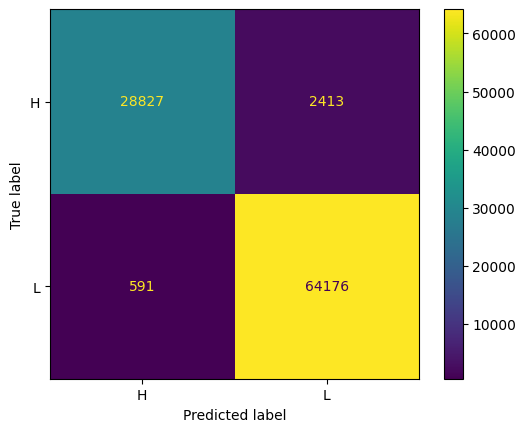

In [111]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")

ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["H","L"]).plot()

In [112]:
# Generate the classification report
print(classification_report(y_test_binary, predictions_binary))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     31240
           1       0.96      0.99      0.98     64767

    accuracy                           0.97     96007
   macro avg       0.97      0.96      0.96     96007
weighted avg       0.97      0.97      0.97     96007



In [ ]:
lstm_model.save_weights('LSTM_Phasic_window_mixed_p4.h5')

In [ ]:
with open("learning_p4.json","w") as file:
  json.dump(fitting.history,file)

# 97% looks the saturation